# 读取数据

In [2]:

import numpy as np
import pandas as pd
from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plt
train_data=pd.read_csv(r"Dataset/cs-training.csv",index_col="Unnamed: 0")
test_data=pd.read_csv(r"Dataset/cs-test.csv",index_col="Unnamed: 0")
column_names=["Default","Balance_r","Age","Worse_1m", "Debt_r","Income","Credit_num","Worse_3m","Estate_num","Worse_2m","Family_num"]
train_data.columns=column_names
test_data.columns=column_names
skew =train_data.skew().sort_values(ascending =False )
skew_df= pd.DataFrame({'skew':skew})
skew_index=skew_df[skew_df>10].dropna().index
log_data=np.log(train_data[skew_index]+1)
train_data1=train_data.copy()
train_data1[skew_index]=log_data
for name in column_names:
    train_data1[name]=winsorize(train_data1[name], limits=[0.005,0.005])

---
## 预处理后的数据概览，分析异常值

In [3]:
train_data.describe()

,Default,Balance_r,Age,Worse_1m,Debt_r,Income,Credit_num,Worse_3m,Estate_num,Worse_2m,Family_num
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


### 重复值

In [4]:
print(train_data.duplicated().value_counts())
print(train_data.duplicated().value_counts())

False    149391
True        609
dtype: int64
False    149391
True        609
dtype: int64


### 查看变量的分位数等信息


In [5]:
train_data.describe().transpose()[['min', '25%', '50%', '75%', 'max']]

,min,25%,50%,75%,max
Default,0.0,0.000000,0.000000,0.000000,1.0
Balance_r,0.0,0.029867,0.154181,0.559046,50708.0
Age,0.0,41.000000,52.000000,63.000000,109.0
Worse_1m,0.0,0.000000,0.000000,0.000000,98.0
Debt_r,0.0,0.175074,0.366508,0.868254,329664.0
Income,0.0,3400.000000,5400.000000,8249.000000,3008750.0
Credit_num,0.0,5.000000,8.000000,11.000000,58.0
Worse_3m,0.0,0.000000,0.000000,0.000000,98.0
Estate_num,0.0,0.000000,1.000000,2.000000,54.0
Worse_2m,0.0,0.000000,0.000000,0.000000,98.0


---
# 初步可视化
### 定义两个画图的函数 方便观察分布时对各个变量复用

In [6]:

import seaborn as sns
import sklearn
from sklearn.feature_selection import mutual_info_classif
#直方图
def plot_distributions_discrete(feature):

    _, axes = plt.subplots(1, 2, figsize=(12,4))
    sns.histplot(train_data[feature], kde=True, label='Train',stat='density',
                 discrete=True, color='steelblue', alpha=0.6, ax=axes[0])
    sns.histplot(test_data[feature], kde=True, label='Test',stat='density',
                 discrete=True, color='gold', alpha=0.25, ax=axes[0])
    axes[0].legend()
    axes[0].set_title('Distr Train set vs Distr Test set')

    sns.boxplot(x='Default', y=feature, data=train_data, ax=axes[1], palette=['gold', 'tan'])

    X = train_data[[feature]].dropna()
    MI = mutual_info_classif(X, train_data.loc[X.index, 'Default'], discrete_features=True,
                             random_state=0)
    axes[1].set_title('Distribution depending on the Default\n-> MI Score : ' + str(round(MI[0], 7)))

    plt.suptitle('"{}" distributions'.format(feature), y=1.15);



In [7]:
# 曲线图
def plot_distributions_continuous(feature):

    _, axes = plt.subplots(1, 2, figsize=(12,4))
    sns.kdeplot(train_data[feature].apply(np.log1p), label='Train',
                color='steelblue', alpha=0.5, shade=True, edgecolor='k', ax=axes[0])
    sns.kdeplot(test_data[feature].apply(np.log1p), label='Test',
                color='gold', alpha=0.3, shade=True, edgecolor='k', ax=axes[0])

    axes[0].legend()
    axes[0].set_title('Distr Train set vs Distr Test set')
    axes[0].set_xlabel('log-{}'.format(feature))

    sns.boxplot(x='Default', y=train_data[feature],
                data=train_data,orient='v', ax=axes[1], palette=['gold', 'tan'])

    X = train_data[[feature]].dropna()
    MI = mutual_info_classif(X, train_data.loc[X.index, 'Default'], random_state=0)
    axes[1].set_title('Distribution depending on the Default\n-> MI Score : ' + str(round(MI[0], 7)))

    plt.suptitle('"{}" distributions'.format(feature), y=1.15);

### 1. Age 年龄
**异常值处理**

E:\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
E:\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
E:\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
E:\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert t

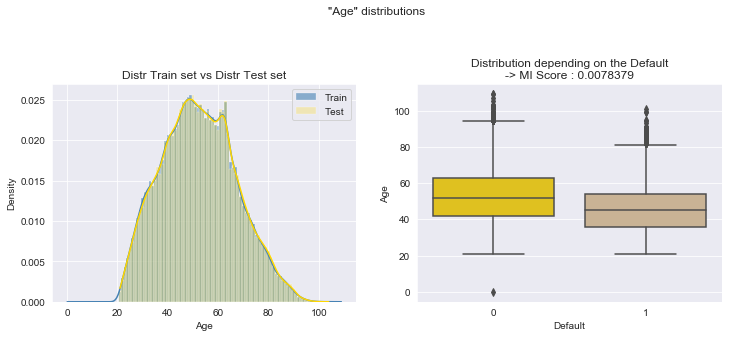

In [8]:
plot_distributions_discrete('Age')

***考虑到未成年人不能办信用卡***

In [9]:
train_data[train_data["Age"]<20]

,Default,Balance_r,Age,Worse_1m,Debt_r,Income,Credit_num,Worse_3m,Estate_num,Worse_2m,Family_num
65696,0,1.0,0,1,0.436927,6000.0,6,0,2,0,2.0


***所以上面一条记录是有误的，删去***

In [10]:
train_data = train_data[train_data["Age"]>=20]

### 2. DebtRatio 支出收入比

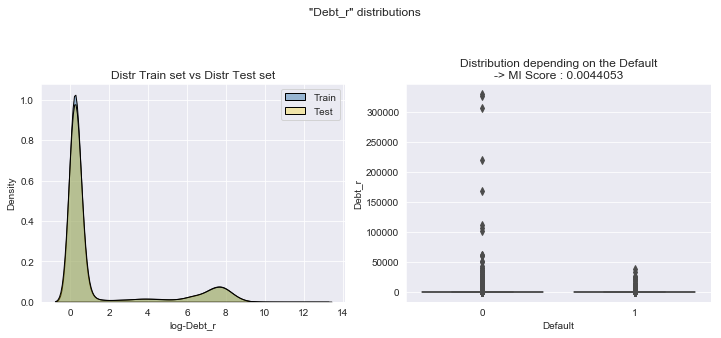

In [11]:
plot_distributions_continuous('Debt_r')

### 3. MonthlyIncome 月收入

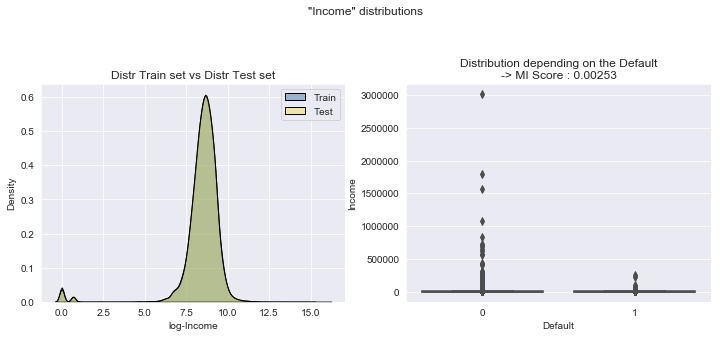

In [12]:
plot_distributions_continuous('Income')

### 4.NumberOfDependents 亲属数

E:\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
E:\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
E:\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
E:\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert t

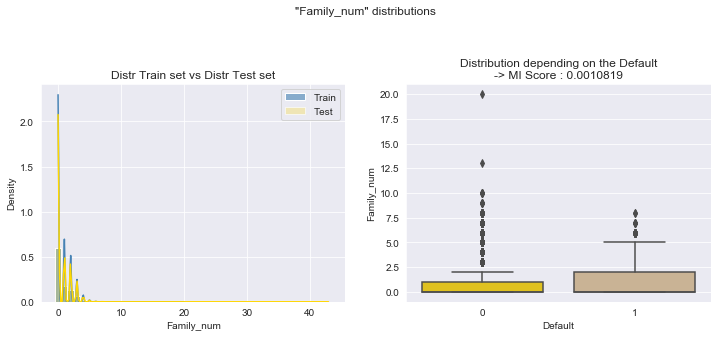

In [13]:
plot_distributions_discrete('Family_num')

### 3.RevolvingUtilizationOfUnsecuredLines 信用情况

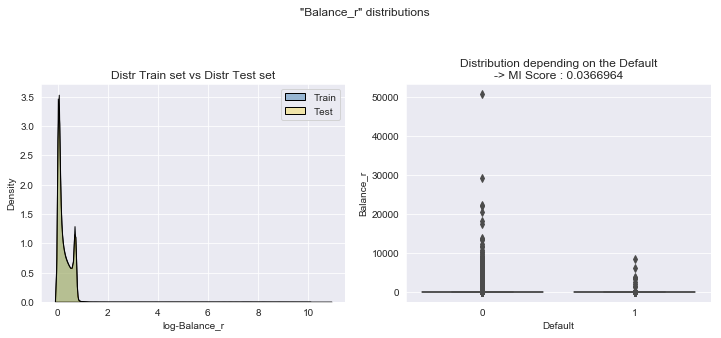

In [14]:
plot_distributions_continuous('Balance_r')

### 整体概览

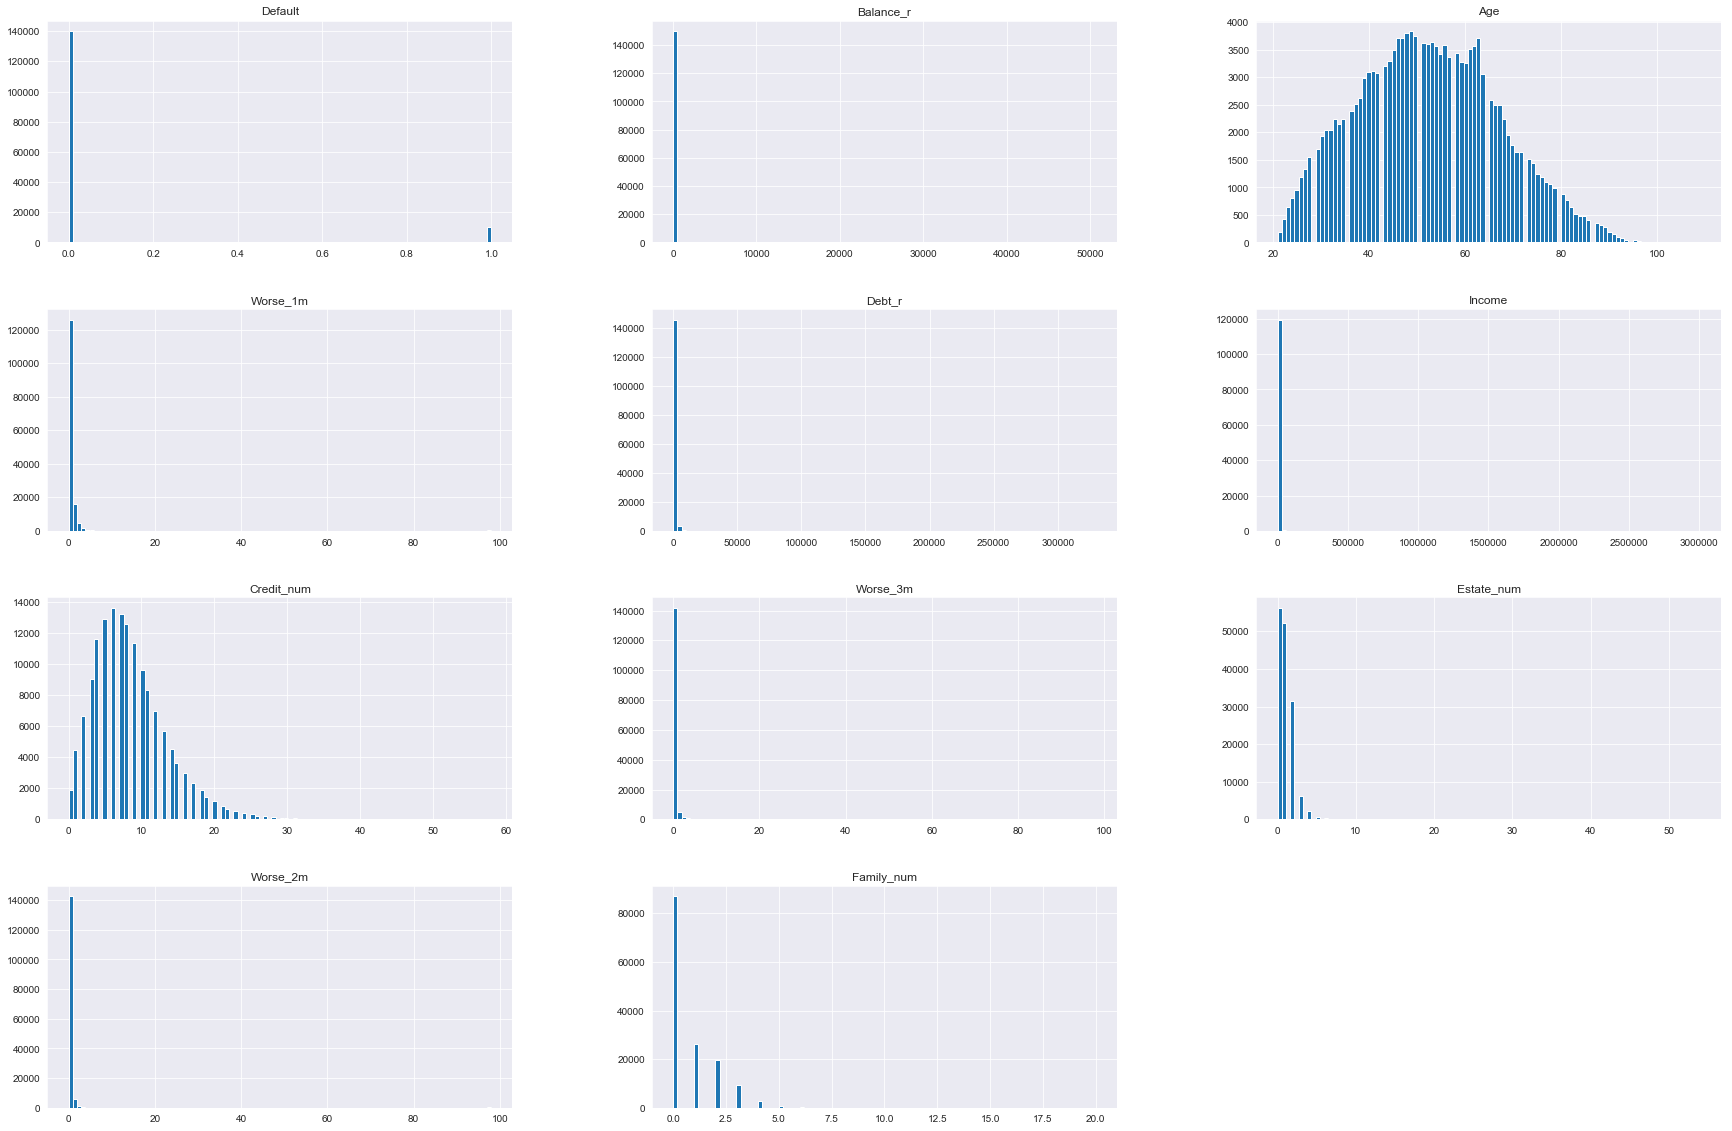

In [15]:
train_data.hist(bins=100, figsize=(30,20))
plt.show()

---
# 特征提取

## k-means聚类

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import statsmodels.api as sm
import os, sys
from scipy.stats.mstats import winsorize
import seaborn as sns
import sklearn
from sklearn.feature_selection import mutual_info_classif

plt.rcParams["font.sans-serif"] = "Times New Roman"
import warnings

warnings.filterwarnings("ignore")


# 禁止函数内部输出
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout


# 读取数据
train_data = pd.read_csv(r"Dataset/cs-training.csv", index_col="Unnamed: 0")
test_data = pd.read_csv(r"Dataset/cs-test.csv", index_col="Unnamed: 0")
column_names = ["Default", "Balance_r", "Age", "Worse_1m", "Debt_r", "Income", "Credit_num", "Worse_3m", "Estate_num",
                "Worse_2m", "Family_num"]
train_data.columns = column_names
test_data.columns = column_names
# 数据预处理

## 缺失值与异常值
# null检验
null_data = pd.DataFrame(pd.isna(train_data).sum(), columns=["Null_num"])
null_data["Null_percentage"] = null_data.Null_num / (train_data.count() + null_data.Null_num)
null_data.Null_percentage = null_data.Null_percentage.apply(lambda x: format(x, ".2%"))
null_data

# 数据特征 summary
train_data.describe().round(2).T
### Balance_r

train_data = train_data[~(train_data["Balance_r"] > 1)]
### 不考虑未成年人的信用

train_data = train_data[~(train_data["Age"] < 20)]

## Outlier 离群值



# 箱型图
def box_view(name):
    plt.figure(figsize=(10, 2))
    sns.boxplot(data=train_data, x=name)
    plt.title(name, size=14)
    plt.show()




# 计算偏度
skew = train_data.skew().sort_values(ascending=False)
skew_df = pd.DataFrame({'skew': skew})

# 将偏度大于10的进行对数变换
skew_index = skew_df[skew_df > 10].dropna().index
log_data = np.log(train_data[skew_index] + 1)
skew_log = log_data.skew().sort_values(ascending=False)
skew_log = pd.DataFrame({'skew': skew_log})
# sns.displot(log_data.Income)
# plt.title("Distribution of log-Income", size=12)


# 得到对数变换后的data, 再次summary并画出箱型图
train_data1 = train_data.copy()
train_data1[skew_index] = log_data
train_data1.describe().round(3).T
# 进行99%的winsorize缩尾处理
for name in column_names:
    train_data1[name] = winsorize(train_data1[name], limits=[0.005, 0.005])

train_data1.describe().round(3).T

E:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


,count,mean,std,min,25%,50%,75%,max
Default,146678.0,0.060,0.237,0.0,0.000,0.000,0.000,1.000
Balance_r,146678.0,0.304,0.338,0.0,0.029,0.144,0.520,1.000
Age,146678.0,52.472,14.711,23.0,41.000,52.000,63.000,89.000
Worse_1m,146678.0,0.134,0.338,0.0,0.000,0.000,0.000,1.792
Debt_r,146678.0,1.527,2.626,0.0,0.161,0.312,0.626,8.731
Income,117495.0,8.415,1.338,0.0,8.137,8.597,9.024,14.917
Credit_num,146678.0,8.474,5.037,0.0,5.000,8.000,11.000,27.000
Worse_3m,146678.0,0.045,0.210,0.0,0.000,0.000,0.000,1.609
Estate_num,146678.0,1.015,1.044,0.0,0.000,1.000,2.000,6.000
Worse_2m,146678.0,0.036,0.168,0.0,0.000,0.000,0.000,1.099


---

In [20]:
from sklearn.cluster import KMeans

data_column_names = [ "Balance_r", "Age", "Worse_1m", "Debt_r", "Income", "Credit_num", "Worse_3m", "Estate_num",
                "Worse_2m", "Family_num"]
data = train_data[data_column_names]
#去除无效值
data = data.dropna()

In [21]:
#归一化
from sklearn.preprocessing import MinMaxScaler
preprocess = MinMaxScaler()
data=pd.DataFrame(preprocess.fit_transform(data))

data

,0,1,2,3,4,5,6,7,8,9
0,0.766127,0.292683,0.020408,1.314070e-05,0.003031,0.224138,0.000000,0.111111,0.0,0.10
1,0.957151,0.231707,0.000000,1.994488e-06,0.000864,0.068966,0.000000,0.000000,0.0,0.05
2,0.658180,0.207317,0.010204,1.392869e-06,0.001011,0.034483,0.010204,0.000000,0.0,0.00
3,0.233810,0.109756,0.000000,5.899484e-07,0.001097,0.086207,0.000000,0.000000,0.0,0.00
4,0.907239,0.341463,0.010204,4.079058e-07,0.021134,0.120690,0.000000,0.018519,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...
117490,0.385742,0.353659,0.000000,6.616200e-06,0.001130,0.120690,0.000000,0.000000,0.0,0.00
117491,0.040674,0.646341,0.000000,3.684238e-06,0.000698,0.068966,0.000000,0.018519,0.0,0.00
117492,0.299745,0.280488,0.000000,1.172645e-05,0.001856,0.068966,0.000000,0.018519,0.0,0.10
117493,0.000000,0.109756,0.000000,0.000000e+00,0.001900,0.068966,0.000000,0.000000,0.0,0.00


In [22]:
#K-Means聚成4类

model=KMeans(n_clusters=4)
model.fit(data)
labels=model.labels_

In [23]:
#加上聚类的label列

r = pd.concat([data, pd.Series(model.labels_, index=data.index)], axis=1)
r.columns = list(data.columns) + [u'label']
r

,0,1,2,3,4,5,6,7,8,9,label
0,0.766127,0.292683,0.020408,1.314070e-05,0.003031,0.224138,0.000000,0.111111,0.0,0.10,1
1,0.957151,0.231707,0.000000,1.994488e-06,0.000864,0.068966,0.000000,0.000000,0.0,0.05,1
2,0.658180,0.207317,0.010204,1.392869e-06,0.001011,0.034483,0.010204,0.000000,0.0,0.00,1
3,0.233810,0.109756,0.000000,5.899484e-07,0.001097,0.086207,0.000000,0.000000,0.0,0.00,2
4,0.907239,0.341463,0.010204,4.079058e-07,0.021134,0.120690,0.000000,0.018519,0.0,0.00,1
...,...,...,...,...,...,...,...,...,...,...,...
117490,0.385742,0.353659,0.000000,6.616200e-06,0.001130,0.120690,0.000000,0.000000,0.0,0.00,0
117491,0.040674,0.646341,0.000000,3.684238e-06,0.000698,0.068966,0.000000,0.018519,0.0,0.00,3
117492,0.299745,0.280488,0.000000,1.172645e-05,0.001856,0.068966,0.000000,0.018519,0.0,0.10,0
117493,0.000000,0.109756,0.000000,0.000000e+00,0.001900,0.068966,0.000000,0.000000,0.0,0.00,2


In [24]:
#统计下各label占比
import collections
data_count2=collections.Counter(labels)
data_count2

Counter({1: 22289, 2: 36109, 3: 35644, 0: 23453})

In [25]:
# T_sne降维跑不动
# 用UMap降维到两维
import umap
reducer = umap.UMAP()
embedding = reducer.fit_transform(r)

Text(0.5,1,'UMAP projection of the dataset')

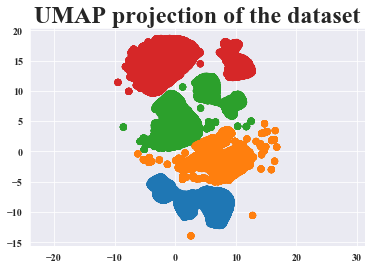

In [27]:
#可视化
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in r.label])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the dataset', fontsize=24)